In [53]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import scipy

import sqlite3
import pandas as pd
import numpy as np
import pandas_profiling
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score
import plotly.graph_objects as go
import plotly.express as px
from statsmodels.stats.outliers_influence import variance_inflation_factor
import re
import string

import shap

# load JS visualization code to notebook
shap.initjs()

# Adding Datasets


Loading given dataset

In [5]:
df = pd.read_excel(
    'data/data.xlsx', sheet_name='School Data')

Loading the historical dataset

In [6]:
df_all = pd.read_csv('data/states_all_extended.csv')

## Some Basic EDA

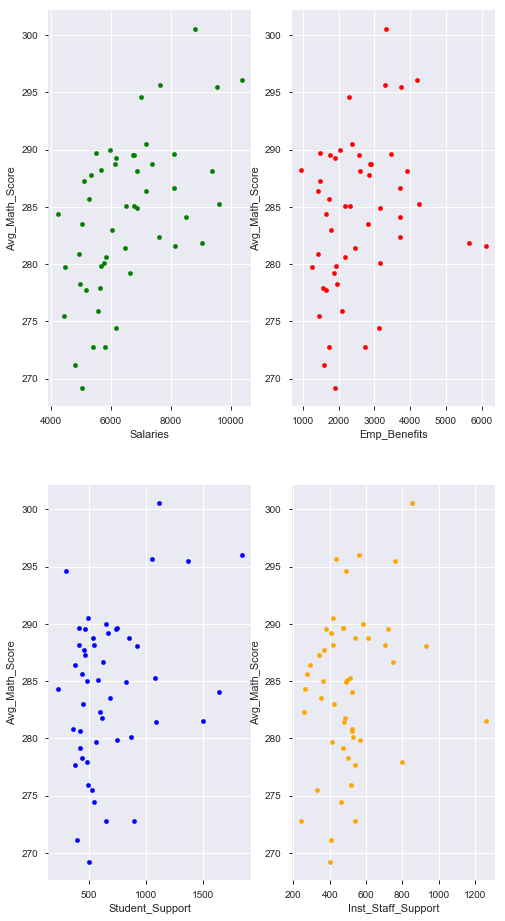

In [4]:
fig = plt.figure(figsize=(8, 16))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

df.plot(x="Salaries", y="Avg_Math_Score", ax=ax1, kind="scatter", c='g')
df.plot(x="Emp_Benefits", y="Avg_Math_Score", ax=ax2, kind="scatter", c='r')
df.plot(x="Student_Support", y="Avg_Math_Score", ax=ax3, kind="scatter", c='b')
df.plot(x="Inst_Staff_Support", y="Avg_Math_Score",
        ax=ax4, kind="scatter", c='orange')
plt.show()

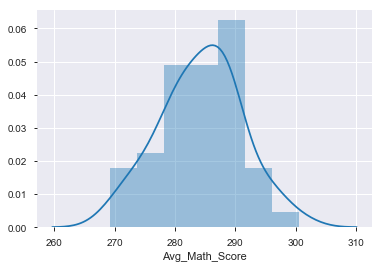

In [5]:
sns.distplot(df.Avg_Math_Score)

### Check for Multi-collinearity

In [6]:
# Get variables for which to compute VIF and add intercept term
V = df[['Salaries', 'Emp_Benefits', 'Student_Support', 'Inst_Staff_Support']]
V['Intercept'] = 1

# Compute and view VIF
vif = pd.DataFrame()
vif["variables"] = V.columns
vif["VIF"] = [variance_inflation_factor(
    V.values, i) for i in range(V.shape[1])]

# View results using print
print(vif)

            variables        VIF
0            Salaries   2.941452
1        Emp_Benefits   2.939339
2     Student_Support   2.165423
3  Inst_Staff_Support   1.455618
4           Intercept  26.443238


**Its Below threshold level, so we can use them**

## Filtering according to same year

In [7]:
df_all = df_all[df_all.YEAR == 2013]

Eliminating US territories

In [8]:
df_all = df_all[:50]

## New Dataframe for all races

Only Eigth Grade students

In [9]:
filter_col = [col for col in df_all if col.startswith('GRADES_8_')]

In [10]:
filter_col

['GRADES_8_G',
 'GRADES_8_AM',
 'GRADES_8_AS',
 'GRADES_8_HI',
 'GRADES_8_BL',
 'GRADES_8_WH',
 'GRADES_8_HP',
 'GRADES_8_TR',
 'GRADES_8_AMM',
 'GRADES_8_AMF',
 'GRADES_8_ASM',
 'GRADES_8_ASF',
 'GRADES_8_HIM',
 'GRADES_8_HIF',
 'GRADES_8_BLM',
 'GRADES_8_BLF',
 'GRADES_8_WHM',
 'GRADES_8_WHF',
 'GRADES_8_HPM',
 'GRADES_8_HPF',
 'GRADES_8_TRM',
 'GRADES_8_TRF']

Remove all the total as we need male and female count

In [11]:
del filter_col[1:8]

In [12]:
df_races = df_all[filter_col]

Index reset

In [13]:
df_races = df_races.reset_index()

In [14]:
df_races = df_races.drop('index', axis=1)

In [15]:
df_races.head(2)

GRADES_8_G  GRADES_8_AMM  GRADES_8_AMF  GRADES_8_ASM  GRADES_8_ASF  \
0     58799.0         263.0         278.0         402.0         400.0   
1      9677.0        1195.0        1105.0         315.0         344.0   

   GRADES_8_HIM  GRADES_8_HIF  GRADES_8_BLM  GRADES_8_BLF  GRADES_8_WHM  \
0        1397.0        1355.0       10111.0        9984.0       17417.0   
1         353.0         320.0         175.0         179.0        2440.0   

   GRADES_8_WHF  GRADES_8_HPM  GRADES_8_HPF  GRADES_8_TRM  GRADES_8_TRF  
0       16549.0          13.0          14.0         309.0         307.0  
1        2264.0         116.0          94.0         417.0         360.0

## Add races to DataFrame

In [16]:
df = pd.concat([df, df_races], axis=1)

## Calculate actual expenditure

Multiply total students with the values

In [17]:
df['salaries'] = df.GRADES_8_G * df.Salaries
df['emp_benefits'] = df.GRADES_8_G * df.Emp_Benefits
df['student_support'] = df.GRADES_8_G * df.Student_Support
df['staff_support'] = df.GRADES_8_G * df.Inst_Staff_Support

In [18]:
df.columns

Index(['State', 'Avg_Math_Score', 'Avg_English_Score', 'Total_Enrollment',
       'State_Debt', 'State_Revenue', 'Salaries', 'Emp_Benefits',
       'Student_Support', 'Inst_Staff_Support', 'Rank', 'GRADES_8_G',
       'GRADES_8_AMM', 'GRADES_8_AMF', 'GRADES_8_ASM', 'GRADES_8_ASF',
       'GRADES_8_HIM', 'GRADES_8_HIF', 'GRADES_8_BLM', 'GRADES_8_BLF',
       'GRADES_8_WHM', 'GRADES_8_WHF', 'GRADES_8_HPM', 'GRADES_8_HPF',
       'GRADES_8_TRM', 'GRADES_8_TRF', 'salaries', 'emp_benefits',
       'student_support', 'staff_support'],
      dtype='object')

## Find expenditure per student

Remove unnecessary columns

In [19]:
df1 = df.drop(['Avg_English_Score', 'Total_Enrollment',
               'State_Debt', 'State_Revenue', 'Salaries', 'Emp_Benefits',
               'Student_Support', 'Inst_Staff_Support'], axis=1)

In [20]:
df1['total_expenditure'] = df1.salaries + \
    df1.emp_benefits + df1.student_support + df1.staff_support

In [21]:
df1['exp_per_student'] = df1.total_expenditure / df1.GRADES_8_G

In [22]:
df1['exp_per_student'].head(5)

0     7831.0
1    17018.0
2     6688.0
3     8477.0
4     8659.0
Name: exp_per_student, dtype: float64

## Remove highly correlated features

In [813]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop.remove('salaries')
to_drop.remove('emp_benefits')

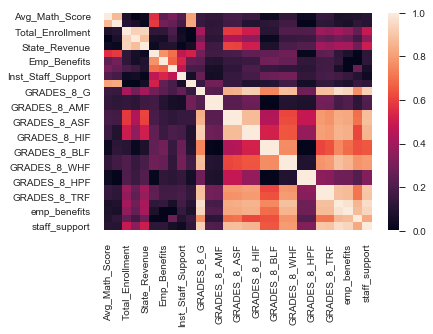

In [814]:
sns.heatmap(corr_matrix)
plt.show()

In [815]:
to_drop

['GRADES_8_AMF',
 'GRADES_8_ASF',
 'GRADES_8_HIF',
 'GRADES_8_BLF',
 'GRADES_8_WHF',
 'GRADES_8_HPF',
 'GRADES_8_TRF',
 'staff_support']

In [55]:
# Create Datafram for regression
df_r = df1

In [817]:
# Drop features
df_r = df_r.drop(df_r[to_drop], axis=1)

In [818]:
df_r = df_r.dropna()
df_r = df_r.drop(columns=['total_expenditure', 'State'])

In [36]:
# Create another copy of dataframe
df2 = df1.dropna()

X and Y for Regression

In [56]:
y = df_r.loc[:, 'Avg_Math_Score'].values


In [821]:
X = df_r.drop(['Avg_Math_Score'], axis=1).loc[:, :].values
X.shape

(50, 12)

# Regression Analysis

## Random Forests

*Performing Grid Search CV to find optimal Hyperparameters*

In [769]:
rf = RandomForestRegressor()

parameters = {'n_estimators': [4, 6, 9],
              'max_features': ['log2', 'sqrt', 'auto'],
              'max_depth': [2, 3, 5, 10],
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]
              }

# Run the grid search
grid_obj = GridSearchCV(rf, parameters, cv=5)
grid_obj = grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
rf = grid_obj.best_estimator_

# Fit the best algorithm to the data.
print('Params ', rf)
print('Score ', rf.score(X, y))

Params  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Score  0.7235244905276368


*Since there are a lot of independent variables, Plot the predicted and original math marks to depict linear relationship*

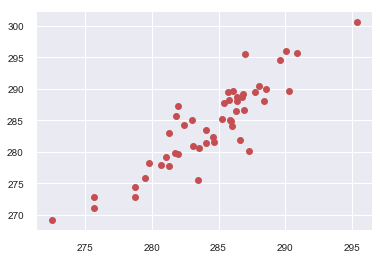

In [770]:
Y_rf = rf.predict(X)
plt.plot(Y_rf, y, 'ro')
plt.show()

In [771]:
feature_importances_rf = pd.DataFrame(rf.feature_importances_,
                                      index=df_r.drop(
                                          ['Avg_Math_Score'], axis=1).columns,
                                      columns=['importance']).sort_values('importance', ascending=False)
feature_importances_rf.head(10)

importance
exp_per_student    0.234840
GRADES_8_TRM       0.115604
salaries           0.098215
student_support    0.097168
GRADES_8_HPM       0.090915
GRADES_8_WHM       0.085085
GRADES_8_HIM       0.072500
emp_benefits       0.068260
GRADES_8_ASM       0.047587
GRADES_8_G         0.045520

## Shap Analysis

In [103]:
X, y = df2[['GRADES_8_AMM', 'GRADES_8_ASM', 'GRADES_8_HIM', 'GRADES_8_BLM', 'GRADES_8_WHM',
            'GRADES_8_HPM', 'GRADES_8_TRM', 'salaries', 'emp_benefits', 'student_support', 'exp_per_student']], df['Avg_Math_Score']

In [105]:
model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                              max_features='sqrt', max_leaf_nodes=None,
                              min_impurity_decrease=0.0, min_impurity_split=None,
                              min_samples_leaf=1, min_samples_split=3,
                              min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=None,
                              oob_score=False, random_state=None, verbose=0, warm_start=False)
model.fit(X, y)

# Fit the best algorithm to the data.
print('Params ', model)
print('Score ', model.score(X, y))

Params  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Score  0.7406716054110672


In [107]:
shap_values = shap.TreeExplainer(model).shap_values(X)
#shap.summary_plot(shap_values, X, plot_type="bar")

In [108]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [109]:
X_output = X.copy()
X_output.loc[:, 'predict'] = np.round(model.predict(X_output), 2)

# Randomly pick some observations
random_picks = np.arange(1, 50, 1)  # Every 50 rows
S = X_output.iloc[random_picks]

In [110]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function


def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value,
                        shap_values_Model[j], S.iloc[[j]])
    return(p)

SHAP FORCE PLOT
* The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [111]:
shap.initjs()
shap_plot(4)
# CAL

In [112]:
shap.initjs()
shap_plot(39)
# RI

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

In [113]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X)

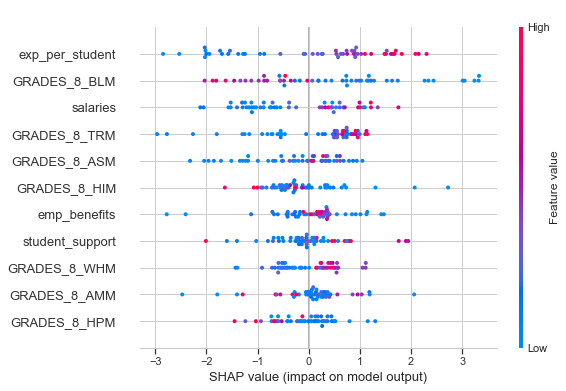

In [71]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

## Profile Pandas

**Create a profile report showing detailed analysis of features and their distributions**


In [318]:
profiler = profile_report.profile_report(title='Pandas Profiling Report')
profiler.to_file(output_file="output.html")

In [856]:
rejected_variables = profiler.get_rejected_variables(threshold=0.93)
rejected_variables

['salaries', 'staff_support']

# EDA with more Data

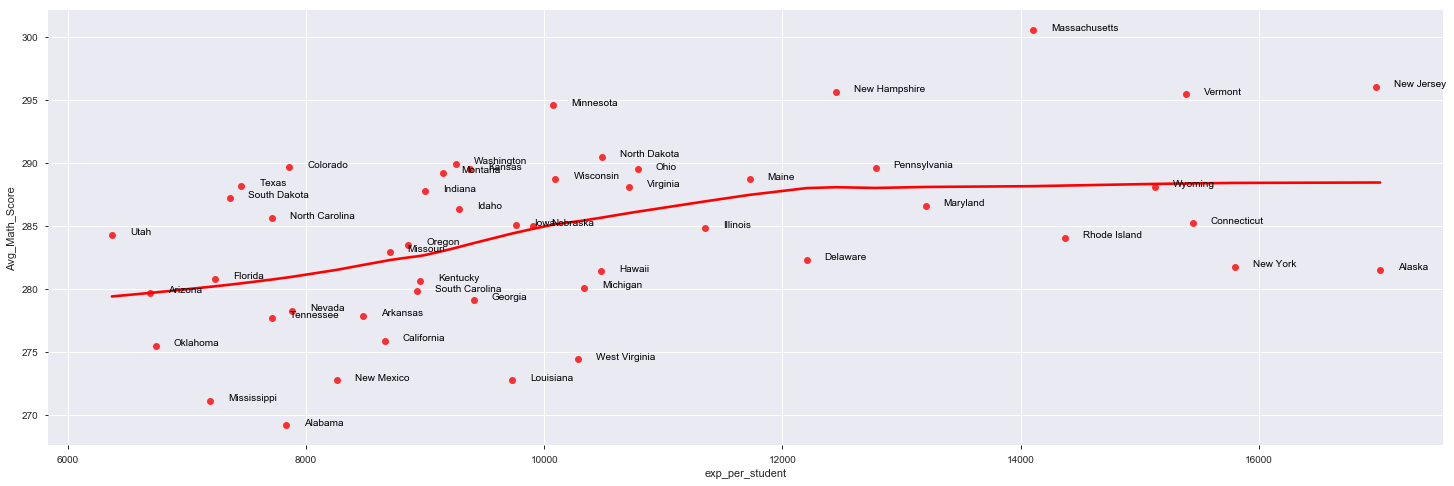

In [25]:
plt.figure(figsize=(25, 8))
p1 = sns.regplot(y='Avg_Math_Score', x='exp_per_student',
                 data=df2, lowess=True, color='red')

for line in range(0, df2.shape[0]):
    p1.text(df2.exp_per_student[line]+151, df2.Avg_Math_Score[line], df.State[line],
            horizontalalignment='left', size='medium', color='black', weight='regular')

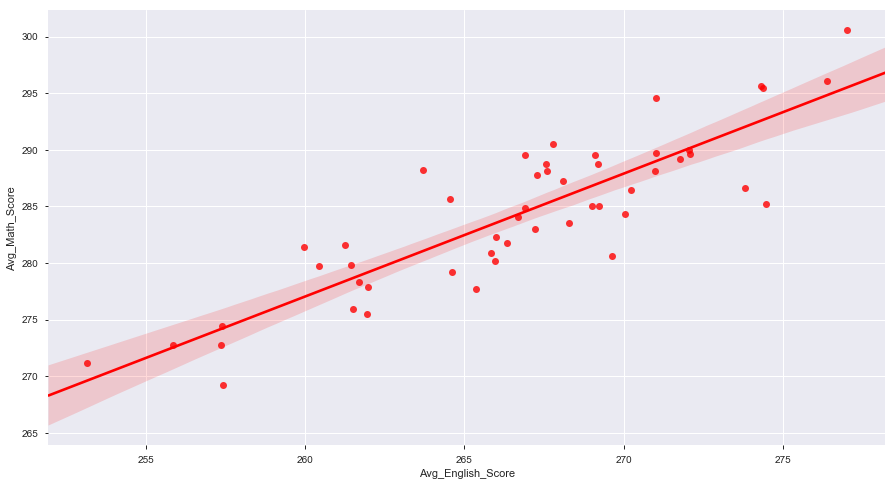

In [14]:
plt.figure(figsize=(15, 8))
p1 = sns.regplot(y='Avg_Math_Score', x='Avg_English_Score',
                 data=df, lowess=False, color='red')

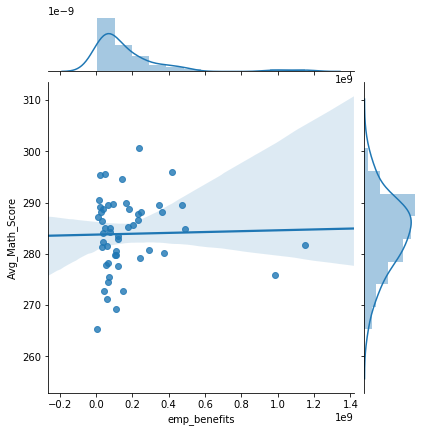

In [34]:
sns.jointplot("emp_benefits", "Avg_Math_Score", data=dfx, kind="reg")

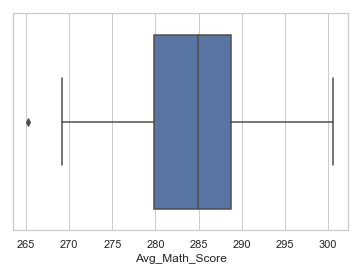

In [35]:
sns.set(style="whitegrid")
sns.boxplot(dfx["Avg_Math_Score"])

In [37]:
fig = px.scatter(df2, x="GRADES_8_ASM", y="GRADES_8_G", hover_data=['State'])
fig.show()

In [39]:
fig = px.scatter(df2, x="GRADES_8_BLM", y="GRADES_8_G", hover_data=['State'])
fig.show()

In [29]:
import plotly.express as px
fig = px.scatter(df2, x="GRADES_8_TRM", y="GRADES_8_G", hover_data=['State'])
fig.show()

In [40]:
import plotly.express as px
fig = px.scatter(df2, x="GRADES_8_HIM", y="GRADES_8_G", hover_data=['State'])
fig.show()

In [28]:
import plotly.express as px
fig = px.scatter(df2, y="Avg_Math_Score",
                 x="exp_per_student", hover_data=['State'])
fig.show()

In [51]:
df2.iloc[8]

State                    Florida
Avg_Math_Score           280.856
Rank                          27
GRADES_8_G                  4425
GRADES_8_AMM                   2
GRADES_8_AMF                   4
GRADES_8_ASM                  30
GRADES_8_ASF                  35
GRADES_8_HIM                 319
GRADES_8_HIF                 303
GRADES_8_BLM                1733
GRADES_8_BLF                1658
GRADES_8_WHM                 140
GRADES_8_WHF                 133
GRADES_8_HPM                   1
GRADES_8_HPF                   2
GRADES_8_TRM                  32
GRADES_8_TRF                  33
salaries             2.18152e+07
emp_benefits          6.2658e+06
student_support      1.60628e+06
staff_support        2.31428e+06
total_expenditure    3.20016e+07
exp_per_student             7232
Name: 8, dtype: object

In [46]:
df2.iloc[31]

State                   New York
Avg_Math_Score           281.808
Rank                          25
GRADES_8_G                 25062
GRADES_8_AMM                1253
GRADES_8_AMF                1209
GRADES_8_ASM                 142
GRADES_8_ASF                 147
GRADES_8_HIM                7682
GRADES_8_HIF                7493
GRADES_8_BLM                 274
GRADES_8_BLF                 235
GRADES_8_WHM                3258
GRADES_8_WHF                3023
GRADES_8_HPM                  12
GRADES_8_HPF                  13
GRADES_8_TRM                 171
GRADES_8_TRF                 150
salaries             2.26661e+08
emp_benefits         1.41751e+08
student_support      1.54131e+07
staff_support        1.21801e+07
total_expenditure    3.96005e+08
exp_per_student            15801
Name: 31, dtype: object

# Add Teachers data

In [25]:
dfx = pd.read_excel('data/state_M2013_dl.xls')

In [26]:
dfx.columns

Index(['AREA', 'ST', 'STATE', 'OCC_CODE', 'OCC_TITLE', 'OCC_GROUP', 'TOT_EMP',
       'EMP_PRSE', 'JOBS_1000', 'LOC_Q', 'H_MEAN', 'A_MEAN', 'MEAN_PRSE',
       'H_PCT10', 'H_PCT25', 'H_MEDIAN', 'H_PCT75', 'H_PCT90', 'A_PCT10',
       'A_PCT25', 'A_MEDIAN', 'A_PCT75', 'A_PCT90', 'ANNUAL', 'HOURLY'],
      dtype='object')

In [27]:
dfx = dfx.drop(['AREA', 'OCC_CODE', 'OCC_GROUP',
                'EMP_PRSE', 'JOBS_1000',  'H_MEAN', 'MEAN_PRSE',
                'H_PCT10', 'H_PCT25', 'H_MEDIAN', 'H_PCT75', 'H_PCT90', 'A_PCT10',
                'A_PCT25', 'A_MEDIAN', 'A_PCT75', 'A_PCT90', 'ANNUAL', 'HOURLY'], axis=1)

In [52]:
value_list2 = ['Middle School Teachers, Except Special and Career/Technical Education', 'Career/Technical Education Teachers, Middle School',

               'Special Education Teachers, Middle School']

value_list = [
    'Middle School Teachers, Except Special and Career/Technical Education']


# Grab DataFrame rows where column has certain values
dfx2 = dfx[dfx.OCC_TITLE.isin(value_list2)]
dfx = dfx[dfx.OCC_TITLE.isin(value_list)]

In [29]:
#dfx.loc[dfx['LOC_Q'] == '**', 'LOC_Q'] = 9
import numpy as np
dfx['LOC_Q'] = np.where(dfx['LOC_Q'] == '**', 5, dfx['LOC_Q'])

In [30]:
dfx['LOC_Q'] = pd.to_numeric(dfx['LOC_Q'])

In [45]:
dfx = dfx.reset_index()

In [30]:
dfx[(dfx['LOC_Q'] > 1.6)]
dfx = dfx.drop([8])
dfx = dfx.drop([51])
dfx = dfx.drop([52])
dfx = dfx.drop([53])

In [41]:
dfx2[(dfx2['ST'] == 'FL')]

ST     STATE                                          OCC_TITLE  \
23244  NY  New York  Middle School Teachers, Except Special and Car...   
23245  NY  New York  Career/Technical Education Teachers, Middle Sc...   
23250  NY  New York          Special Education Teachers, Middle School   

      TOT_EMP LOC_Q A_MEAN  
23244   39890  0.98  75340  
23245    1670  1.41  74530  
23250   11520  1.83  73770

In [58]:
df_male = df2[['GRADES_8_AMM', 'GRADES_8_ASM', 'GRADES_8_HIM', 'GRADES_8_BLM',
               'GRADES_8_WHM', 'GRADES_8_HPM', 'GRADES_8_TRM']]

In [59]:
df_male['m_race'] = df_male.idxmax(axis=1)

In [60]:
df_states = df2['State']

In [61]:
df_male = pd.concat([df_male, df_states], axis=1)

In [62]:
fig = px.bar(df_male, x='m_race', y='State')
fig.show()

In [63]:
fig = go.Figure(data=go.Choropleth(
    locations=dfx['ST'],  # Spatial coordinates
    z=df2['Avg_Math_Score'],  # Data to be color-coded
    locationmode='USA-states',  # set of locations match entries in `locations`
    colorscale='reds',
    colorbar_title="Average Math Score",
))

fig.update_layout(
    title_text='Avg Math',
    geo=dict(
        scope='usa',
        projection=go.layout.geo.Projection(type='albers usa'),
        showlakes=True,  # lakes
        lakecolor='rgb(255, 255, 255)'),  # limite map scope to USA
)

fig.show()

In [64]:
vc = df_male['m_race'].value_counts()
vc

GRADES_8_WHM    42
GRADES_8_HIM     5
GRADES_8_BLM     2
GRADES_8_ASM     1
Name: m_race, dtype: int64

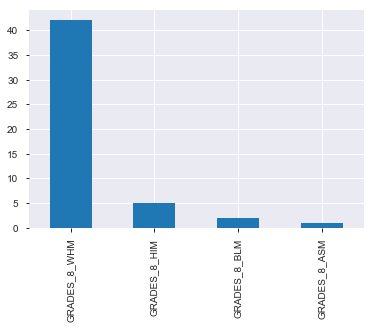

In [65]:
df_male['m_race'].value_counts().plot.bar()

In [66]:
fig = go.Figure(data=go.Choropleth(
    locations=dfx['ST'],  # Spatial coordinates
    z=dfx['LOC_Q'],  # Data to be color-coded
    locationmode='USA-states',  # set of locations match entries in `locations`
    colorscale='Picnic',
    colorbar_title=" Location Quotient",
))

fig.update_layout(
    title_text='Location Quotient',
    geo=dict(
        scope='usa',
        projection=go.layout.geo.Projection(type='albers usa'),
        showlakes=True,  # lakes
        lakecolor='rgb(255, 255, 255)'),  # limite map scope to USA
)

fig.show()

In [67]:
import plotly.graph_objects as go
import plotly.express as px
fig = go.Figure(data=go.Choropleth(
    locations=dfx['ST'],  # Spatial coordinates
    z=dfx['A_MEAN'],  # Data to be color-coded
    locationmode='USA-states',  # set of locations match entries in `locations`
    colorscale='Greys',
    colorbar_title="Salary",
))

fig.update_layout(
    title_text='Annual Salary of Teachers',
    geo=dict(
        scope='usa',
        projection=go.layout.geo.Projection(type='albers usa'),
        showlakes=True,  # lakes
        lakecolor='rgb(255, 255, 255)'),  # limite map scope to USA
)

fig.show()

In [68]:
fig = px.scatter(df2, y="Avg_Math_Score", x="Rank", hover_data=['State'])
fig.update_traces(textposition='top left')
fig.show()

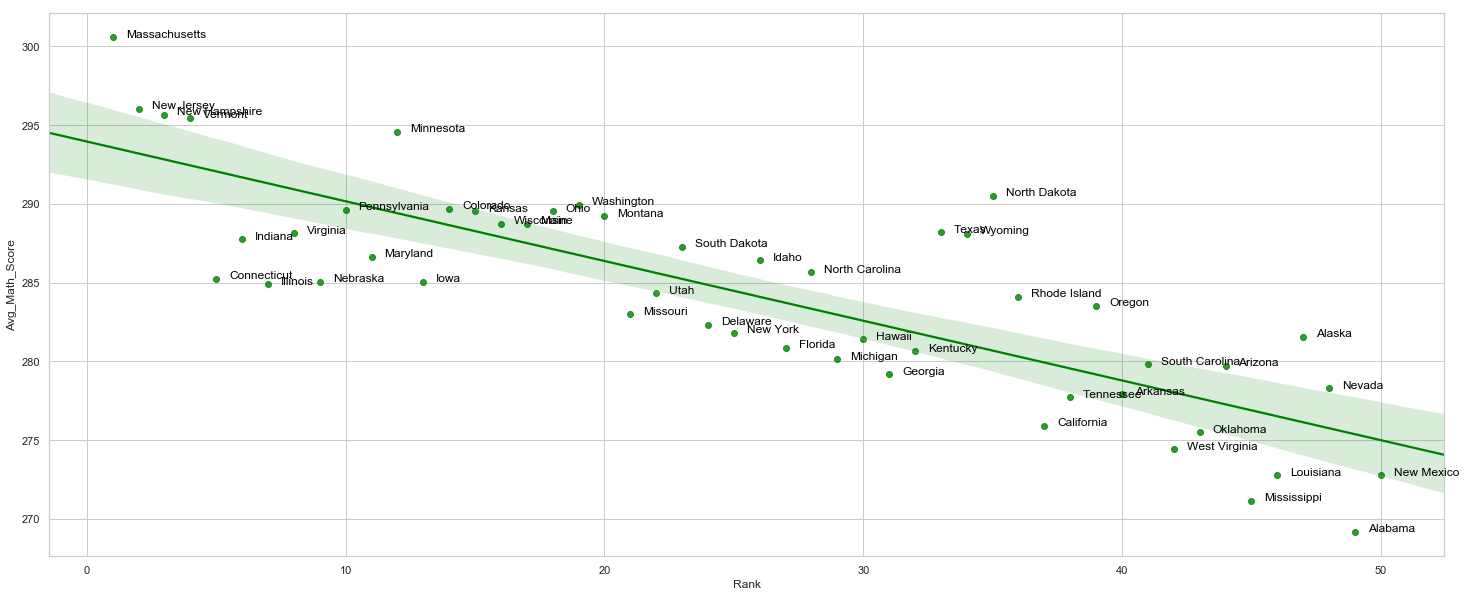

In [330]:
plt.figure(figsize=(25, 10))
rg = sns.regplot(y='Avg_Math_Score', x='Rank',
                 data=df2, lowess=False, color='green')

for line in range(0, df2.shape[0]):
    rg.text(df2.Rank[line]+0.5, df2.Avg_Math_Score[line], df.State[line],
            horizontalalignment='left', size='medium', color='black', weight='regular')

# Compare expenditure

In [63]:
df_exp = df2[['Avg_Math_Score', 'State', 'salaries', 'emp_benefits', 'student_support',
              'staff_support']]

In [68]:
state1 = 'Massachusetts'

In [69]:
filter3 = df_exp['State'].str.contains(state1)

In [70]:
exp1 = df_exp[filter3]

In [71]:
df11 = pd.concat([exp, exp1])
df11 = df11.drop('Avg_Math_Score', axis=1)

In [72]:
df_melt = pd.melt(df11, id_vars=['State'], var_name='expenditure')
df_melt

State      expenditure         value
0   Rhode Island         salaries  1.168175e+09
1  Massachusetts         salaries  5.498047e+08
2   Rhode Island     emp_benefits  5.082365e+08
3  Massachusetts     emp_benefits  2.065974e+08
4   Rhode Island  student_support  2.247388e+08
5  Massachusetts  student_support  6.930206e+07
6   Rhode Island    staff_support  7.166381e+07
7  Massachusetts    staff_support  5.334763e+07

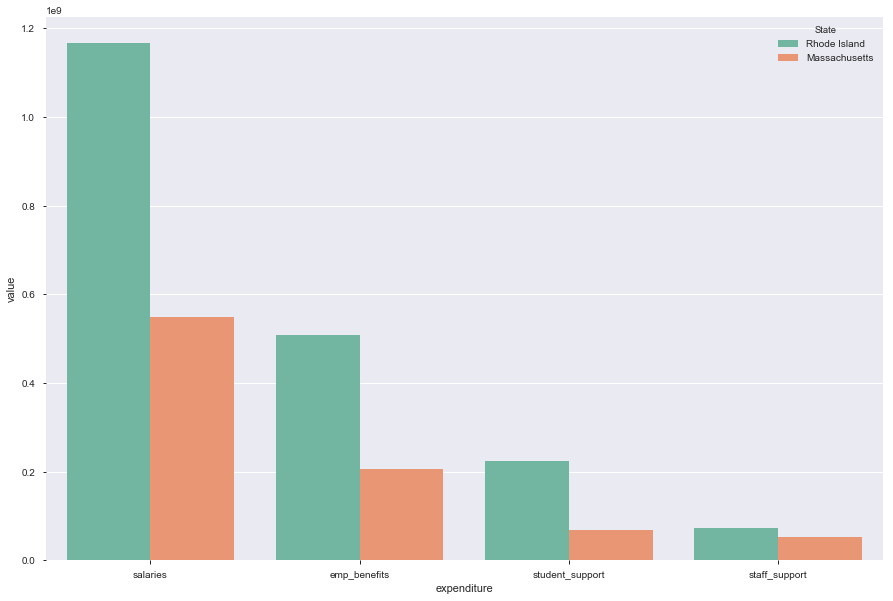

In [73]:
plt.figure(figsize=(15, 10))
sns.barplot(x='expenditure', y='value', hue='State',
            data=df_melt, palette="Set2")

# Student Teacher Ratio

In [47]:
st_ratio = df2['GRADES_8_G'] / dfx['TOT_EMP']

In [50]:
st_ratio = st_ratio.astype(int)

In [52]:
df2['st_ratio'] = st_ratio

In [54]:
df2['LOC_Q'] = dfx['LOC_Q']

In [55]:
df2['m_race'] = df_male['m_race']

## Final Dataframe 

In [59]:
df_new_features = df2[['State', 'Avg_Math_Score', 'Rank',
                       'st_ratio', 'LOC_Q', 'exp_per_student', 'm_race']]

In [60]:
df_new_features

State  Avg_Math_Score  Rank  st_ratio  LOC_Q  exp_per_student  \
0          Alabama        269.1943    49         6   1.04           7831.0   
1           Alaska        281.5596    47         5   1.13          17018.0   
2          Arizona        279.7223    44         8   0.83           6688.0   
3         Arkansas        277.9148    40         5   1.26           8477.0   
4       California        275.9014    37         9   0.69           8659.0   
5         Colorado        289.6818    14         4   1.19           7857.0   
6      Connecticut        285.2440     5         4   1.29          15446.0   
7         Delaware        282.3383    24         4   1.10          12202.0   
8          Florida        280.8558    27         0   0.90           7232.0   
9          Georgia        279.1791    31         9   1.23           9406.0   
10          Hawaii        281.4129    30        75   0.62          10475.0   
11           Idaho        286.4139    26         5   0.79           9285.0   
12        Illinois        284.8976     7         0   1.19          11352.0   
13         Indiana        287.7677     6        14   0.80           8996.0   
14            Iowa        285.0701    13        12   0.91           9762.0   
15          Kansas        289.5183    15         6   0.95           9375.0   
16        Kentucky        280.6454    32         4   1.01           8958.0   
17       Louisiana        272.7610    46         4   1.27           9731.0   
18           Maine        288.7312    17        19   1.05          11724.0   
19        Maryland        286.6414    11         1   1.13          13202.0   
20   Massachusetts        300.5682     1         3   1.11          14105.0   
21        Michigan        280.1336    29         4   0.88          10333.0   
22       Minnesota        294.5930    12        13   0.71          10072.0   
23     Mississippi        271.1610    45         8   1.50           7196.0   
24        Missouri        282.9885    21         2   1.18           8702.0   
25         Montana        289.2285    20        35   0.94           9149.0   
26        Nebraska        285.0613     9         3   0.73           9904.0   
27          Nevada        278.2867    48         5   0.77           7885.0   
28   New Hampshire        295.6651     3         8   1.42          12451.0   
29      New Jersey        296.0534     2         0   1.29          16985.0   
30      New Mexico        272.7618    50        27   1.00           8263.0   
31        New York        281.8078    25         0   0.98          15801.0   
32  North Carolina        285.6454    28        11   0.94           7716.0   
33    North Dakota        290.5151    35       107   0.55          10487.0   
34            Ohio        289.5281    18         0   1.12          10783.0   
35        Oklahoma        275.5067    43        17   1.03           6736.0   
36          Oregon        283.5246    39         8   0.70           8859.0   
37    Pennsylvania        289.6237    10         1   0.89          12781.0   
38    Rhode Island        284.0922    36        57   1.11          14370.0   
39  South Carolina        279.8246    41         1   1.07           8928.0   
40    South Dakota        287.2704    23        29   1.03           7361.0   
41       Tennessee        277.7201    38         0   0.95           7715.0   
42           Texas        288.1990    33         1   1.40           7457.0   
43            Utah        284.3315    22        86   0.75           6369.0   
44         Vermont        295.4696     4        33   0.99          15388.0   
45        Virginia        288.1430     8         0   1.00          10711.0   
46      Washington        289.9570    19         9   0.75           9255.0   
47   West Virginia        274.4301    42        15   1.51          10285.0   
48       Wisconsin        288.7458    16         1   0.84          10093.0   
49         Wyoming        288.1191    34        58   0.82          15125.0   

          m_race  
0   GRADES_8_WH